In [1]:
import os

os.environ['OPENBLAS_NUM_THREADS'] = '20'
os.environ['MKL_NUM_THREADS'] = '20'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy import interpolate
import random

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.insert(1,'/home/jsperezc/jupyter/AQ_Forecast/functions/')
from preprocessing import *
import forecasting
from plotting import *


Últimas actualizaciones:

 11 de noviembre de 2022 
1. Se agrega la función plot_prom_movil_ICA al subpaquete airquality.plots, el cual devuelve un gráfico con el promedio móvil, ya sea teniendo en cuanta el ICA o no.
        Ej. plots.plot_prom_movil_ICA(var='PM2.5', Fechai=Fechai, Fechaf=Fechaf, ICA=False, rolling='168H')

 22 de noviembre de 2022 
2. Se agrega la función plot_any_location_map al subpaquete airquality.plots, el cual grafica el valle de aburra o algunos de sus municipios como una imagen satelital
    o DEM. Asimismo, se le puede entregar una bloque de código a la función para la graficación de información geográfica cualquiera que el usuario desee.

 23 de noviembre de 2022 
3. Se actualiza la función airquality.color. Asimismo, se agrega la función colorbar_customized en airquality.color, el cual
   permite la creación de barra de colores personalizadas a partir de una lista de colores creada por el usuario.
     Ej. my_colors_ramp = ['#23a9fa', '#2abad9', '#24968b'

2023-05-02 16:55:42.057042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-02 16:55:42.057067: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_ForeICA24h_pob(date_forecast, path_output):
    #Importando librerías
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    import datetime as dt

    #Importando airquality
    import sys
    sys.path.append('/home/calidadaire/Paquete/')
    import airquality.read_data as aqread
    
    #Definiendo directorio de salida
    dirout_figs = path_output
    
    #Fecha para la lectura del pronóstico
    year = str(date_forecast.year)
    month = str(date_forecast.month).zfill(2)
    day = str(date_forecast.day).zfill(2)
    hour = str(date_forecast.hour).zfill(2)
    
    #Definiendo estaciones
    AQStats = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA",
               "MED-VILL", "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI",
               "MED-ARAN", "BEL-FEVE", "ENV-HOSP", "SAB-RAME", "MED-SELE"]
    
    #Para leer información del pronóstico
    datei_for = '{0}-{1}-{2} {3}:00'.format(year, month, day, hour)
    #Para leer información de las observaciones (hasta antes de la hora de inicialización)
    datef_obs = (pd.to_datetime(datei_for) - pd.Timedelta(hours=1)).strftime('%Y-%m-%d %H:%M')
    datei_obs = (pd.to_datetime(datef_obs) - pd.Timedelta(days=1)).strftime('%Y-%m-%d %H:%M')

    #Cargando datos requeridos calidad del aire
    DataObs_PM25 = aqread.PM25(Fechai=datei_obs, Fechaf=datef_obs, estaciones=AQStats)
    DataObs_PM25 = DataObs_PM25.data

    #Creando DataFrame para almacenar la información
    DFTotal_PM25 = pd.DataFrame(DataObs_PM25.mean(axis=0))
    #Dando estructura al DF
    for idx in range(1, 25):
        DFTotal_PM25[idx] = np.nan
    
    
    #Leyendo archivo del pronóstico (con base en la fecha)
    filename = '{0}{1}{2}_{3}.csv'.format(year, month, day, hour)

    #Recorriendo las estaciones
    for aqsta in AQStats:
        #Directorio de entrada
        dirin_data = '/var/data1/AQ_Forecast_DATA/results/{0}/csv/'.format(aqsta)
        #Obteniendo información
        try:
            DataFore_PM25 = pd.read_csv(dirin_data + filename, index_col=[0], parse_dates=[0],
                                        infer_datetime_format=True)
            DataFore_PM25 = DataFore_PM25.mean(axis=1).iloc[:24]
        except:
            continue

        #Guardando información en DataFrame
        DFTotal_PM25.loc[aqsta, range(1, 25)] = DataFore_PM25.values

    #Ordenando dataframe en función de la concentración pronosticada a 6 horas
    DFTotal_PM25.sort_values(6, ascending=False, inplace=True)
    
    
    #GRAFICANDO INFORMACIÓN
    #Definiendo paleta de colores en función del ICA
    import matplotlib as mpl
    cmap = mpl.colors.ListedColormap(['#00ab5c','#ffff01','#fea500','#fe0000','#873ac0'])
    ICAval = [0, 12.6, 37.6, 55.6, 150, 501]
    norm = mpl.colors.BoundaryNorm(ICAval, cmap.N)

    #Creando figura
    fig, ax = plt.subplots(figsize=(12, 12))

    #Graficando información
    ax.imshow(DFTotal_PM25.values, cmap=cmap, norm=norm)

    #Parámetros adicionales
    ax.set_yticks(range(len(DFTotal_PM25)))
    ax.set_yticklabels(DFTotal_PM25.index)
    ax.set_xticks(range(0, 25))
    ax.set_xticklabels(['Now'] + ['+'+str(i) for i in range(1, 25)])
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_aspect(0.7)
    ax.axvline(0.5, color='black', linestyle=':')
    ax.set_xlabel('Horas (pronóstico)', fontsize=12, labelpad=10)
    ax.xaxis.set_label_position('top')


    #Añadiendo grillas
    # Minor ticks
    ax.set_xticks(np.arange(-.5, 25, 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(DFTotal_PM25), 1), minor=True)
    #Grid
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    #Eliminando minor ticks
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    for tick in ax.yaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    #Estableciendo fecha inicial del pronóstico
    plt.title('Fecha inicial del pronóstico: '+str(date_forecast)+ ' HL',
              fontsize=14, loc='left')
    
    
    #Definiendo listas con la información requerida para la leyenda
    Labels = ['Buena', 'Aceptable', 'Dañina grupos sensibles', 'Dañina', 'Muy dañina']
    Colors = ['#00ab5c','#ffff01','#fea500','#fe0000','#873ac0']

    handles = [Patch(facecolor=color, label=label) for label, color in zip(Labels, Colors)]

    #Añadiendo leyenda
    ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(0., -0.01), ncol=5, fontsize=12.5,
              edgecolor='white', handletextpad=0.6)
    
    #Añadiendo texto
    t1 = ("* Esta figura muestra el pronóstico del Índice de Calidad del Aire (ICA) para diferentes estaciones poblacionales\nde calidad del aire del Valle de Aburrá.\n\n"
          "* Now se refiere al ICA de las últimas 24 horas (observado).\n\n"
          "* Los pronósticos se indican con el signo + y la hora en el futuro a la que se está pronosticando.\nPor ejemplo: +6 indica el pronóstico a 6 horas.\n\n")
    text1 = plt.figtext(0.125, 0.15, t1, fontsize=11, wrap=True, horizontalalignment='left')


    #Guardando y mostrando la figura
    plt.savefig(dirout_figs, dpi=300, bbox_inches='tight')
    plt.close()   

In [8]:
### FUNCIÓN PARA GRAFICAR FIGURA DE CUADRITOS (PRONÓSTICO)
def plot_ForeICA24h_4old(date_forecast, path_output, AQStats, ytext=0.15):
    #Importando librerías
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    import datetime as dt

    #Importando airquality
    import sys
    sys.path.append('/home/calidadaire/Paquete/')
    import airquality.read_data as aqread

    #Definiendo directorio de salida
    dirout_figs = path_output
    
    ### ---- Solo para pruebas ----
    #date_forecast = pd.to_datetime('2023-02-21 17:00')
    #AQStats = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA",
    # "MED-VILL", "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI",
    # "MED-ARAN", "BEL-FEVE", "ENV-HOSP", "SAB-RAME", "MED-SELE","CEN-TRAF"]
    #dirout_figs = './TestICA.png'
    #ytext = 0.12
    

    #Fecha para la lectura del pronóstico
    year = str(date_forecast.year)
    month = str(date_forecast.month).zfill(2)
    day = str(date_forecast.day).zfill(2)
    hour = str(date_forecast.hour).zfill(2)

    #Para leer información del pronóstico
    datei_for = '{0}-{1}-{2} {3}:00'.format(year, month, day, hour)
    #Para leer información de las observaciones (hasta antes de la hora de inicialización)
    datef_obs = (pd.to_datetime(datei_for) - pd.Timedelta(hours=1)).strftime('%Y-%m-%d %H:%M')
    datei_obs = (pd.to_datetime(datef_obs) - pd.Timedelta(days=1)).strftime('%Y-%m-%d %H:%M')

    #Cargando datos requeridos calidad del aire
    DataObs_PM25 = aqread.PM25(Fechai=datei_obs, Fechaf=datef_obs, estaciones=AQStats)
    DataObs_PM25 = DataObs_PM25.data
    
    #Definiendo modelos para promediar (ensamble)
    model_names_ensamble = model_names.copy()
    model_names_ensamble.remove('CAMS')


    #Creando DataFrame para almacenar la información
    DFTotal_PM25 = pd.DataFrame(DataObs_PM25.mean(axis=0))
    #Dando estructura al DF
    for idx in range(1, 25):
        DFTotal_PM25[idx] = np.nan


    #Recorriendo las estaciones
    for aqsta in AQStats:
        #Directorio de entrada
        dirin_data = '/var/data1/AQ_Forecast_DATA/results_oldv/tables/stations/archive/{0}/'.format(aqsta)
        #Leyendo archivo del pronóstico (con base en la fecha y estación)
        filename = 'Fc_{0}_{1}{2}{3}_{4}0000.csv'.format(aqsta, year, month, day, hour)
        
        #dirin_data = '/var/data1/AQ_Forecast_DATA/results_oldv/{0}/csv/'.format(aqsta)
        #Obteniendo información
        try:
            DataFore_PM25 = pd.read_csv(dirin_data + filename, index_col=[0], parse_dates=[0],
                                        infer_datetime_format=True)
            #Limitando a 24 horas y obteniendo el promedio de la estación
            
            DataFore_PM25_sta = DataFore_PM25.iloc[:23].loc[:, model_names_ensamble].mean(axis=1).copy()
            #Obteniendo observaciones de las últimas 23 horas
            DataObs_PM25_sta = DataObs_PM25.loc[:, aqsta].iloc[1:].copy()
            
            #Uniendo información y obteniendo media móvil de 24 horas
            Concat_PM25ObsFor_sta = pd.concat([DataObs_PM25_sta, DataFore_PM25_sta])
            DataFore_PM25_sta_24h = Concat_PM25ObsFor_sta.rolling(window=24, min_periods=18).mean().iloc[-24:]

        except:
            continue
        
        #Guardando información en DataFrame
        DFTotal_PM25.loc[aqsta, range(1, 25)] = DataFore_PM25_sta_24h.values

    #Ordenando dataframe en función de la concentración pronosticada a 6 horas
    DFTotal_PM25.sort_values(6, ascending=False, inplace=True)
    
    
    #GRAFICANDO INFORMACIÓN
    #Definiendo paleta de colores en función del ICA
    import matplotlib as mpl
    cmap = mpl.colors.ListedColormap(['#00ab5c','#ffff01','#fea500','#fe0000','#873ac0'])
    ICAval = [0, 12.6, 37.6, 55.6, 150, 501]
    norm = mpl.colors.BoundaryNorm(ICAval, cmap.N)

    #Creando figura
    fig, ax = plt.subplots(figsize=(12, 12))

    #Graficando información
    ax.imshow(DFTotal_PM25.values, cmap=cmap, norm=norm)

    #Parámetros adicionales
    ax.set_yticks(range(len(DFTotal_PM25)))
    ax.set_yticklabels(DFTotal_PM25.index)
    ax.set_xticks(range(0, 25))
    ax.set_xticklabels(['Now'] + ['+'+str(i) for i in range(1, 25)])
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_aspect(0.7)
    ax.axvline(0.5, color='black', linestyle=':')
    ax.set_xlabel('Horas (pronóstico)', fontsize=12, labelpad=10)
    ax.xaxis.set_label_position('top')


    #Añadiendo grillas
    # Minor ticks
    ax.set_xticks(np.arange(-.5, 25, 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(DFTotal_PM25), 1), minor=True)
    #Grid
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    #Eliminando minor ticks
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    for tick in ax.yaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    #Estableciendo fecha inicial del pronóstico
    plt.title('Fecha inicial del pronóstico: '+str(date_forecast)+ ' HL',
              fontsize=14, loc='left')
    
    
    #Definiendo listas con la información requerida para la leyenda
    Labels = ['Buena', 'Aceptable', 'Dañina grupos sensibles', 'Dañina', 'Muy dañina']
    Colors = ['#00ab5c','#ffff01','#fea500','#fe0000','#873ac0']

    handles = [Patch(facecolor=color, label=label) for label, color in zip(Labels, Colors)]

    #Añadiendo leyenda
    ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(0., -0.01), ncol=5, fontsize=12.5,
              edgecolor='white', handletextpad=0.6)
    
    #Añadiendo texto
    t1 = ("* Esta figura muestra el pronóstico del Índice de Calidad del Aire (ICA) para diferentes estaciones poblacionales\nde calidad del aire del Valle de Aburrá.\n\n"
          "* Now se refiere al ICA de las últimas 24 horas (observado).\n\n"
          "* Los pronósticos se indican con el signo + y la hora en el futuro a la que se está pronosticando.\nPor ejemplo: +6 indica el pronóstico a 6 horas.\n\n")
    text1 = plt.figtext(0.125, ytext, t1, fontsize=11, wrap=True, horizontalalignment='left')


    #Guardando y mostrando la figura
    plt.savefig(dirout_figs, dpi=300, bbox_inches='tight')
    plt.close()   


In [11]:
### FIGURA DE PRONÓSTICO DE CALIDAD DEL AIRE (CUADRITOS) PARA LAS ESTACIONES POECA
datetime_now = dt.datetime.now()
forecast_initial_date = datetime_now.replace(hour=16, minute = 0,second=0,microsecond=0)
#Definiendo estaciones
AQStats = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA",
            "MED-VILL", "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI",
            "MED-ARAN", "BEL-FEVE", "ENV-HOSP", "SAB-RAME", "MED-SELE"]

#Definiendo path
path_fig = 'ForecastICA24h_SummaryPOECA_current.png'
#Graficando
model_names = ['LR','MLP','RF','SVR','KNN','CAMS']
plot_ForeICA24h_4old(forecast_initial_date, path_fig, AQStats)


In [2]:
stations = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA", "MED-VILL",
            "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI", "MED-ARAN", "BEL-FEVE", "ENV-HOSP", 
            "SAB-RAME", "MED-SELE","CEN-TRAF","SUR-TRAF"]

models = ['GB_MO','GB_CH','RF_MO','RF_CH']#,'LR_MO','LR_RC']

In [6]:
datetime_now

datetime.datetime(2023, 1, 30, 19, 9, 40, 735345)

In [5]:
datetime_now.replace(minute = 0,second=0,microsecond=0)

datetime.datetime(2023, 1, 30, 19, 0)

In [3]:
dic_forecasts = {}
dic_probs_dataframes = {}
dic_pm2p5={}
# for i_station in range(len(stations)):
for i_station in [0]:
    datetime_now = dt.datetime.now()-dt.timedelta(hours=72)
    station = stations[i_station]
    print(station)
    forecast_initial_date = datetime_now.replace(minute = 0,second=0,microsecond=0)
    forecast_initial_date = 

    ### Collect inputs ###
    index_future, x_temp, pm2p5, df_GFS, df_CAMS, df_IFRP = get_inputs_for_forecast(station, forecast_initial_date)
    
    break

ITA-CJUS


IndexError: positional indexers are out-of-bounds

In [4]:
forecast_initial_date

datetime.datetime(2023, 1, 30, 19, 0)

In [70]:
datetime_now = dt.datetime.now()-dt.timedelta(hours=72)
print(station)
forecast_initial_date = datetime_now.replace(minute = 0,second=0,microsecond=0)
station = 'ITA-CJUS'


pm2p5 = get_pm2p5_for_forecast(forecast_initial_date-dt.timedelta(hours=1),station_name=station)
pm2p5.index = pm2p5.index+dt.timedelta(hours=1)

ITA-CJUS


In [132]:
datetime_now = dt.datetime.now()#-dt.timedelta(hours=1)
print(station)
forecast_initial_date = datetime_now.replace(minute = 0,second=0,microsecond=0)
station = 'ITA-CJUS'
AQdata = read.PM25(str(forecast_initial_date-dt.timedelta(hours = 96)), str(forecast_initial_date), estaciones=[station]).data

ITA-CJUS


In [133]:
AQdata

,ITA-CJUS
2022-09-29 11:00:00,11.0
2022-09-29 12:00:00,8.0
2022-09-29 13:00:00,12.0
2022-09-29 14:00:00,8.0
2022-09-29 15:00:00,15.0
...,...
2022-10-02 20:00:00,11.0
2022-10-02 21:00:00,9.0
2022-10-02 22:00:00,4.0
2022-10-02 23:00:00,3.0


In [117]:
forecast_initial_date

datetime.datetime(2022, 10, 1, 19, 0)

In [47]:
import pandas as pd
import sys
sys.path.insert(1,'/home/jsperezc/jupyter/AQ_Forecast/functions/')
sys.path.append('/home/calidadaire/Paquete/')
import airquality.read_data as read
import numpy as np
import xarray as xr
import datetime as dt
import glob
import postprocessing
import copy
import os

def recorte_datos(path_files, coordenadas):
    """
    Esta funcion Permite recortar archivos NetCDF o GRIB haciendo uso de la libreria xarray.
    
    Para esto, debe ingresar la ruta del directorio donde estan los archivos a recortar, ademas de un vector con las coordenadas 
    en las siguientes posiciones: [N,S,E,O] 
    
    Tenga en cuenta que se guardara el nuevo archivo con el mismo nombre que el archivo original, es decir, se va a sobreescribir 
    este ultimo
    """
    import xarray as xr
    import os
    import glob
    
    Files = glob.glob(path_files+'*')
    Name_Files = os.listdir(path_files)
    for i,file in enumerate(Files):
        global_data = xr.open_dataset(file)
        lon = global_data.coords["lon"]
        lat = global_data.coords["lat"]

        #Hacemos el recorte de los datos a nuestra region de interés
        split_data = global_data.loc[dict(lon=lon[(lon > coordenadas[3]) & (lon < coordenadas[2])], 
                                          lat=lat[(lat > coordenadas[1]) & (lat < coordenadas[0])])] 

        #Guardamos el nuevo NetCDf
        split_data.to_netcdf(path_files+Name_Files[i], 
                                  unlimited_dims='time',format="NETCDF4_CLASSIC") 
        
def get_pm2p5_period(initial_date,final_date,station_name=None):

    df_pm2p5 = read.PM25(str(initial_date),\
                         str(final_date)).data
    trained_stations = ['ITA-CJUS','CAL-LASA','ITA-CONC','MED-LAYE','CAL-JOAR','EST-HOSP','MED-ALTA','MED-VILL',
                        'BAR-TORR','COP-CVID','MED-BEME','MED-TESO','MED-SCRI','MED-ARAN','BEL-FEVE','ENV-HOSP',
                        'SAB-RAME','MED-SELE']

    if station_name==None:
        df_pm2p5 = df_pm2p5[trained_stations]
        df_pm2p5 = pd.DataFrame(df_pm2p5.mean(axis=1),columns=['PM2.5'])
        df_pm2p5 = df_pm2p5.interpolate(limit=12)
    else:
        df_pm2p5 = pd.DataFrame(df_pm2p5[station_name].values,index=df_pm2p5.index,columns=['PM2.5'])
        df_pm2p5 = df_pm2p5.interpolate(limit=12)
    return df_pm2p5

def get_gfs_for_forecast(forecast_initial_date,path_data,\
    gfs_correlations_path = '/var/data1/AQ_Forecast_DATA/historic/GFS/correlations',\
    operational = True, latlon = None):
    ## forecast_date_0: initial hour of forecast (last hour in which pm2.5 data is available)
    ## path_data: folder with this type of files: gfs_0p25_2021050112.nc
    ## gfs_correlations_path: path with pm2.5 vs gfs variables correlation matrices (for optimally averaging)
    ## operational: False when it is a historic run
    ## latlon: coordenates of station, if None the output will be the mean for the Aburra Valley
    
    ### We need to get data for the next 5 days and the past day, then optimally average them
    gfs_files_names = np.sort(glob.glob(path_data+'gfs_0p25_*.nc'))
#     print(gfs_files_names)
    initial_dates_gfs_files = np.array([dt.datetime.strptime(gfs_files_names[i].split('_')[-1].split('.')[0],\
        '%Y%m%d%H') for i in range(len(gfs_files_names))])
#     print(initial_dates_gfs_files)
    ### For operational run one simply takes the last two available files, for historic run we need to know
    ### the real delay of data (8 hours)
    
    latency = 8 # hours
    if operational == True:
        gfs_2_files = gfs_files_names[-2:]
    else:
        gfs_2_files = gfs_files_names[np.where(initial_dates_gfs_files - dt.timedelta(hours = 5) \
            <= forecast_initial_date - dt.timedelta(hours = latency))[0]][-2:]
    
    ### Read the files and keep the most updated value
    dataset_1 = xr.open_mfdataset(gfs_2_files[0])
    dataset_2 = xr.open_mfdataset(gfs_2_files[1])
    gfs_total = xr.concat([dataset_1,dataset_2], dim = "time")
    gfs_recorte = postprocessing.recorte_espacial(gfs_total)
    
    lat = gfs_recorte.latitude.values
    lon = gfs_recorte.longitude.values
    tcc = gfs_recorte.tcc_atm_avg.values
    rad = gfs_recorte.rad_in.values
    prate = gfs_recorte.prate_srf_avg.values
    hpbl = gfs_recorte.hpbl.values
    cin = gfs_recorte.cin.values
    
    if latlon == None: ## Get mean series
        mean_tcc = np.mean(gfs_recorte.tcc_atm_avg[:],axis = [1,2]).values #%
        mean_rad = np.mean(gfs_recorte.rad_in[:],axis = [1,2]).values #W/m2
        mean_prate = np.mean(gfs_recorte.prate_srf_avg[:],axis = [1,2]).values #kg m*-2 s*-1
        mean_hpbl = np.mean(gfs_recorte.hpbl[:],axis = [1,2]).values #m
        mean_cin = np.mean(gfs_recorte.cin[:],axis = [1,2]).values #J kg**-1

        df_GFS = pd.DataFrame(np.array([mean_tcc,mean_rad,mean_prate,mean_hpbl,mean_cin]).T,
                             index = gfs_recorte.time,columns = ['tcc','rad','prate','hpbl','cin'])
        df_GFS['prate'] = df_GFS['prate']*60*60
        df_GFS_temp = df_GFS.reset_index()
        df_GFS = df_GFS_temp.drop_duplicates("index",keep= "last") ## Esto para eliminar los datos que se solapan entre las diferentes corridas
        ## y conservar el último, que sería el más actualizado (última descarga)
        df_GFS.set_index("index", inplace=True)
        df_GFS.index = df_GFS.index-dt.timedelta(hours = 1.5)
        df_GFS_hourly = df_GFS.resample('H').mean().interpolate(method = 'linear',order = 3)
        df_GFS_hourly.index = df_GFS_hourly.index - dt.timedelta(hours = 5)

    else: ## Nearest point
        lat_station = latlon[0]
        lon_station = latlon[1]
        ilon = np.argmin(abs(lon_station-lon))
        ilat = np.argmin(abs(lat_station-lat))
        tcc_temp = tcc[:,ilat,ilon] #%
        rad_temp = rad[:,ilat,ilon] #W/m2
        prate_temp = prate[:,ilat,ilon] #kg m*-2 s*-1
        hpbl_temp = hpbl[:,ilat,ilon] #m
        cin_temp = cin[:,ilat,ilon] #J kg**-1
        df_GFS = pd.DataFrame(np.array([tcc_temp,rad_temp,prate_temp,hpbl_temp,cin_temp]).T,
                             index = gfs_recorte.time,columns = ['tcc','rad','prate','hpbl','cin'])
        df_GFS['prate'] = df_GFS['prate']*60*60
        df_GFS_temp = df_GFS.reset_index()
        df_GFS = df_GFS_temp.drop_duplicates("index",keep= "last") ## Esto para eliminar los datos que se solapan entre las diferentes corridas
        ## y conservar el último, que sería el más actualizado (última descarga)
        df_GFS.set_index("index", inplace=True)
        df_GFS.index = df_GFS.index-dt.timedelta(hours = 1.5)
        df_GFS_hourly = df_GFS.resample('H').mean().interpolate(method = 'linear',order = 3)
        df_GFS_hourly.index = df_GFS_hourly.index - dt.timedelta(hours = 5)
    
    keys_gfs = np.array(df_GFS_hourly.keys()).astype(str)
    
    ### Now get optimal average
    df_optimal = pd.DataFrame(index = df_GFS_hourly.index)
    for variable in keys_gfs:
        df_optimal_temp = copy.deepcopy(df_GFS_hourly[[variable]])
        for hour in range(0,24):
            optimal_window = get_optimal_window(variable,hour,gfs_correlations_path)
            df_optimal_temp[df_optimal_temp.index.hour == hour] = df_GFS_hourly[[variable]].rolling(optimal_window,min_periods=1).mean()\
                [df_optimal_temp.index.hour == hour]
        df_optimal[variable] = df_optimal_temp
        
    return df_GFS_hourly,df_optimal

def get_cams_for_forecast(forecast_initial_date,path_data,operational = True,latlon=None):
    ## forecast_date_0: initial hour of forecast (last hour in which pm2.5 data is available)
    ## path_data: if historic run then folder cams forecast subdirectory: year/month/CAMS_date_hour.nc
    ## gfs_correlations_path: path with pm2.5 vs gfs variables correlation matrices (for optimally averaging)
    ## operational: False when it is a historic run
    ## latlon: coordenates of station, if None the output will be the mean for the Aburra Valley
    
    latency = 10 # hours
    
    if operational == False:
        files_cams = []
        dirs_cams = []
        for root, dirs, files in os.walk(path_data,followlinks=True):
            for file in files:
                files_cams.append(file)
            for dirtemp in dirs:
                dirs_cams.append(dirtemp)
        files_cams = np.sort(files_cams)
        initial_dates_cams_files = np.array([dt.datetime.strptime(files_cams[i].split('/')[-1].split('.')[0],\
            'CAMS_%Y%m%d_%H%M%S') for i in range(len(files_cams))])
        cams_2_files = [files_cams[np.where(initial_dates_cams_files - dt.timedelta(hours = 5) \
            <= forecast_initial_date - dt.timedelta(hours = latency))[0]][-1]]
        tempfile1 = path_data+cams_2_files[0].split('_')[1][:4]+'/'+cams_2_files[0].split('_')[1][4:6]+'/'+cams_2_files[0]
        cams_2_files = [tempfile1]
    else:
        files_cams = np.sort(glob.glob(path_data+'CAMS_*_*.nc'))
        initial_dates_cams_files = np.array([dt.datetime.strptime(files_cams[i].split('/')[-1].split('.')[0],\
            'CAMS_%Y%m%d_%H%M%S') for i in range(len(files_cams))])
        cams_2_files = files_cams[-1]
    ### Read the files and keep the most updated value
#     print(cams_2_files)
    dataset_1 = xr.open_mfdataset(cams_2_files)
    cams_total = xr.concat([dataset_1], dim = "time")
    cams_recorte = postprocessing.recorte_espacial(cams_total)
    variables_cams = ['aod550','bcaod550','pm2p5','duaod550','omaod550','ssaod550','niaod550','amaod550','suaod550']
#     variables_cams = ['aod550','bcaod550','pm2p5']
    
    lat = cams_recorte.latitude.values
    lon = cams_recorte.longitude.values

    if latlon == None: ## Get mean series
        dic_cams = {}
        for variable in variables_cams:
            dic_cams[variable] = np.mean(cams_recorte[variable][:],axis = [1,2]).values
        df_CAMS = pd.DataFrame(dic_cams,index = cams_recorte.time)
        df_CAMS['pm2p5'] = df_CAMS['pm2p5'] * 1000_000_000 #ug/m3
    else: ## Nearest point
        lat_station = latlon[0]
        lon_station = latlon[1]
        ilon = np.argmin(abs(lon_station-lon))
        ilat = np.argmin(abs(lat_station-lat))

        dic_cams = {}
        for variable in variables_cams:
            dic_cams[variable] = cams_recorte[variable][:,ilat,ilon].values
        df_CAMS = pd.DataFrame(dic_cams,index = cams_recorte.time)
        df_CAMS['pm2p5'] = df_CAMS['pm2p5'] * 1000_000_000 #ug/m3
    
    df_CAMS.index = df_CAMS.index - dt.timedelta(hours = 5)

#     df_CAMS = df_CAMS[['aod550','bcaod550','pm2p5']]
    df_CAMS = df_CAMS[['aod550','bcaod550','pm2p5','duaod550','omaod550','ssaod550','niaod550','amaod550','suaod550']]
    df_CAMS.columns = ['aod','bcaod','pm2p5_cams','duaod','omaod','ssaod','niaod','amaod','suaod']
#     df_CAMS.columns = ['aod','bcaod','pm2p5_cams']    
#     print(df_CAMS)
    df_optimal_cams = pd.DataFrame(index = df_CAMS.index)
    df_optimal_cams['aod'] = df_CAMS.aod.rolling(3,min_periods=1).mean()
#     df_optimal_cams['ssaod'] = df_CAMS.ssaod.rolling(9,min_periods=1).mean()
#     df_optimal_cams['omaod'] = df_CAMS.omaod.rolling(12,min_periods=1).mean()
#     df_optimal_cams['duaod'] = df_CAMS.duaod.rolling(1,min_periods=1).mean()
    df_optimal_cams['bcaod'] = df_CAMS.bcaod.rolling(1,min_periods=1).mean()
    df_optimal_cams['pm2p5_cams'] = df_CAMS.pm2p5_cams.rolling(3,min_periods=1).mean()
    
    return df_CAMS,df_optimal_cams

def get_optimal_window(variable,hour,gfs_correlations_path):
    return np.argmax(abs(np.load(gfs_correlations_path+'/CorrsAnomsGFS_'+variable+'_v3.npy')[:,hour]))+1

def get_pm2p5_for_forecast(forecast_initial_date,station_name=None):
    df_pm2p5 = read.PM25(str(forecast_initial_date-dt.timedelta(hours = 96)),\
                         str(forecast_initial_date)).data
    trained_stations = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA", "MED-VILL",
            "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI", "MED-ARAN", "BEL-FEVE", "ENV-HOSP", 
            "SAB-RAME", "MED-SELE","CEN-TRAF","SUR-TRAF"]
    
    if station_name==None:
        df_pm2p5 = df_pm2p5[trained_stations]
        df_pm2p5 = pd.DataFrame(df_pm2p5.mean(axis=1),columns=['PM2.5'])
        df_pm2p5 = df_pm2p5.interpolate(limit=24)
    else:
        df_pm2p5 = pd.DataFrame(df_pm2p5[station_name].values,index=df_pm2p5.index,columns=['PM2.5'])
        df_pm2p5 = df_pm2p5.interpolate(limit=24)
    return df_pm2p5



In [88]:
station = 'ITA-CJUS'
datetime_now = dt.datetime.now()-dt.timedelta(hours=24)
forecast_initial_date = datetime_now.replace(minute = 0,second=0,microsecond=0)


gfs_path = '/var/data1/AQ_Forecast_DATA/operational/GFS/'
cams_path = '/var/data1/AQ_Forecast_DATA/historic/CAMS/Pronostico/'
path_IFRP ="/var/data1/AQ_Forecast_DATA/historic/GFS/historic/Vientos/BT/IFRP/"
files_ifrp = np.sort(glob.glob(path_IFRP+'*'))
dates_ifrp = np.array([dt.datetime.strptime(files_ifrp[i].split('/')[-1][:-4],'%Y%m%d%H')\
    for i in range(len(files_ifrp))])

coor_esta= pd.read_csv("/var/data1/AQ_Forecast_DATA/historic/PM25/CoordenadasEstaciones.csv", 
                       index_col= "Nombre")
lat_est = coor_esta.loc[station].Latitud
lon_est = coor_esta.loc[station].Longitud

# Get PM2.5

pm2p5 = get_pm2p5_for_forecast(forecast_initial_date-dt.timedelta(hours=1),station_name=station)
pm2p5.index = pm2p5.index+dt.timedelta(hours=1)

### Get GFS and CAMS ###
df_GFS,df_optimal_gfs = get_gfs_for_forecast(forecast_initial_date,\
    gfs_path,operational = False,latlon = (lat_est,lon_est))
df_CAMS,df_optimal_cams = get_cams_for_forecast(forecast_initial_date,\
    cams_path,operational = False,latlon = (lat_est,lon_est))

### Get IFRP
file_ifrp = files_ifrp[dates_ifrp<=forecast_initial_date+\
           dt.timedelta(hours=5)-dt.timedelta(hours=5)][-1]
df_IFRP = pd.read_csv(file_ifrp,index_col=1,parse_dates=True)[['IFRP']]
df_IFRP.index = df_IFRP.index-dt.timedelta(hours=5)

# Lagged data
x_shifts = pm2p5.loc[forecast_initial_date-dt.timedelta(hours=47):forecast_initial_date].values[:,0]

index_future = pd.date_range(forecast_initial_date+dt.timedelta(hours=1),\
              forecast_initial_date+dt.timedelta(hours=96),freq='H')

# CAMS
cams_future = df_optimal_cams.loc[index_future[0]:].iloc[np.arange(0,97,3),:]
aod_future = cams_future['aod'].values

# GFS
gfs_future = df_optimal_gfs.loc[index_future[0]:].iloc[np.arange(0,97,3),:]
tcc_future = gfs_future['tcc'].values
prate_future = gfs_future['prate'].values
hpbl_future = gfs_future['hpbl'].values

# IFRP
ifrp50_future = df_IFRP.rolling(3,center=True).max().loc[index_future[0]:].iloc[np.arange(0,97,3),0].values

# HOD/DOW
df_hour = pd.DataFrame(index_future.hour, index = index_future)
hod1_future = np.sin(2*np.pi*(df_hour/24)).iloc[np.arange(0,24,1),0].values
hod2_future = np.cos(2*np.pi*(df_hour/24)).iloc[np.arange(0,24,1),0].values

df_dow = pd.DataFrame(index_future.dayofweek, index = index_future)
dow1_future = np.sin(2*np.pi*(df_dow/7)).iloc[np.arange(0,96,24),0].values
dow2_future = np.cos(2*np.pi*(df_dow/7)).iloc[np.arange(0,96,24),0].values

x_temp = np.hstack([x_shifts,
    aod_future,
    tcc_future,
    prate_future,
    hpbl_future,
    ifrp50_future,
    dow1_future,
    dow2_future,
    hod1_future,
    hod2_future])
    


In [90]:
df_forecasts = forecasting.forecast_station(x_temp,index_future,station,models)

In [91]:
df_forecasts

,GB_MO,GB_CH,RF_MO,RF_CH
2022-10-02 12:00:00,22.428444,22.469315,26.776961,27.708558
2022-10-02 13:00:00,21.921366,22.349101,29.476417,29.264896
2022-10-02 14:00:00,22.477375,21.781830,28.388432,26.540284
2022-10-02 15:00:00,22.716933,22.887241,26.678930,27.317106
2022-10-02 16:00:00,21.554181,23.579466,27.228953,28.263280
...,...,...,...,...
2022-10-06 07:00:00,30.020495,29.746392,32.139724,30.038052
2022-10-06 08:00:00,29.528682,30.021998,31.182518,31.664444
2022-10-06 09:00:00,29.774790,30.338503,31.324718,30.389070
2022-10-06 10:00:00,30.526192,30.825323,28.801084,31.620815


## Replicando error

In [30]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.insert(1,'/home/jsperezc/jupyter/AQ_Forecast/functions/')
from preprocessing import *
import forecasting
from plotting import *

stations = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA", "MED-VILL",
            "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI", "MED-ARAN", "BEL-FEVE", "ENV-HOSP", 
            "SAB-RAME", "MED-SELE","CEN-TRAF","SUR-TRAF"]

models = ['GB_MO','GB_CH','RF_MO','RF_CH']#,'LR_MO','LR_RC']

dic_forecasts = {}
dic_probs_dataframes = {}
dic_pm2p5 = {}
for i_station in range(len(stations)):
    datetime_now = dt.datetime.now()#-dt.timedelta(hours=1)
    station = stations[i_station]
    station = "CEN-TRAF"
    print(station)
    forecast_initial_date = datetime_now.replace(minute = 0,second=0,microsecond=0)

    ### Collect inputs ###
    index_future, x_temp, pm2p5, df_GFS, df_CAMS, df_IFRP = get_inputs_for_forecast(station, forecast_initial_date)


CEN-TRAF


IndexError: positional indexers are out-of-bounds

## Corriendo script por partes

In [5]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy import interpolate
import random
import traceback

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.insert(1,'/home/jsperezc/jupyter/AQ_Forecast/functions/')
from preprocessing import *
import forecasting
from plotting import *

stations = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA", "MED-VILL",
            "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI", "MED-ARAN", "BEL-FEVE", "ENV-HOSP", 
            "SAB-RAME", "MED-SELE","CEN-TRAF","SUR-TRAF"]
stations = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA", "MED-VILL",
            "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI", "MED-ARAN", "BEL-FEVE", "ENV-HOSP", 
            "SAB-RAME", "MED-SELE","CEN-TRAF"]

models = ['GB_MO','GB_CH','RF_MO','RF_CH']#,'LR_MO','LR_RC']

dic_forecasts = {}
dic_probs_dataframes = {}
dic_pm2p5 = {}
for i_station in range(len(stations)):

    datetime_now = dt.datetime.now()#-dt.timedelta(hours=1)
    station = stations[i_station]
    print(station)
    forecast_initial_date = datetime_now.replace(minute = 0,second=0,microsecond=0)

    ### Collect inputs ###
    #index_future, x_temp, pm2p5, df_GFS, df_CAMS, df_IFRP = get_inputs_for_forecast(station, forecast_initial_date)


2023-02-02 20:28:33.653264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-02 20:28:33.653287: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ITA-CJUS
ITA-CONC
MED-LAYE
CAL-JOAR
EST-HOSP
MED-ALTA
MED-VILL
BAR-TORR
COP-CVID
MED-BEME
MED-TESO
MED-SCRI
MED-ARAN
BEL-FEVE
ENV-HOSP
SAB-RAME
MED-SELE
CEN-TRAF


In [6]:
gfs_path = '/var/data1/AQ_Forecast_DATA/operational/GFS/'
cams_path = '/var/data1/AQ_Forecast_DATA/historic/CAMS/Pronostico/'
path_IFRP ="/var/data1/AQ_Forecast_DATA/historic/GFS/historic/Vientos/BT/IFRP/"
files_ifrp = np.sort(glob.glob(path_IFRP+'*'))
dates_ifrp = np.array([dt.datetime.strptime(files_ifrp[i].split('/')[-1][:-4],'%Y%m%d%H')\
    for i in range(len(files_ifrp))])

coor_esta= pd.read_csv("/var/data1/AQ_Forecast_DATA/historic/PM25/CoordenadasEstaciones.csv", 
                       index_col= "Nombre")
lat_est = coor_esta.loc[station].Latitud
lon_est = coor_esta.loc[station].Longitud

# Get PM2.5

pm2p5 = get_pm2p5_for_forecast(forecast_initial_date-dt.timedelta(hours=1),station_name=station)
pm2p5.index = pm2p5.index+dt.timedelta(hours=1)

In [7]:
station

'CEN-TRAF'

In [3]:
#Parámetros para get_gfs_for_forecast
forecast_initial_date=forecast_initial_date
path_data=gfs_path
gfs_correlations_path = '/var/data1/AQ_Forecast_DATA/historic/GFS/correlations'
operational = False
latlon = (lat_est,lon_est)


### We need to get data for the next 5 days and the past day, then optimally average them
gfs_files_names = np.sort(glob.glob(path_data+'gfs_0p25_*.nc'))
#     print(gfs_files_names)
initial_dates_gfs_files = np.array([dt.datetime.strptime(gfs_files_names[i].split('_')[-1].split('.')[0],\
    '%Y%m%d%H') for i in range(len(gfs_files_names))])
#     print(initial_dates_gfs_files)
### For operational run one simply takes the last two available files, for historic run we need to know
### the real delay of data (8 hours)

latency = 8 # hours
if operational == True:
    gfs_2_files = gfs_files_names[-2:]
else:
    gfs_2_files = gfs_files_names[np.where(initial_dates_gfs_files - dt.timedelta(hours = 5) \
        <= forecast_initial_date - dt.timedelta(hours = latency))[0]][-2:]

### Read the files and keep the most updated value
dataset_1 = xr.open_mfdataset(gfs_2_files[0])
dataset_2 = xr.open_mfdataset(gfs_2_files[1])
gfs_total = xr.concat([dataset_1,dataset_2], dim = "time")
gfs_recorte = postprocessing.recorte_espacial(gfs_total)

lat = gfs_recorte.latitude.values
lon = gfs_recorte.longitude.values
tcc = gfs_recorte.tcc_atm_avg.values
rad = gfs_recorte.rad_in.values
prate = gfs_recorte.prate_srf_avg.values
hpbl = gfs_recorte.hpbl.values
cin = gfs_recorte.cin.values

if latlon == None: ## Get mean series
    mean_tcc = np.mean(gfs_recorte.tcc_atm_avg[:],axis = [1,2]).values #%
    mean_rad = np.mean(gfs_recorte.rad_in[:],axis = [1,2]).values #W/m2
    mean_prate = np.mean(gfs_recorte.prate_srf_avg[:],axis = [1,2]).values #kg m*-2 s*-1
    mean_hpbl = np.mean(gfs_recorte.hpbl[:],axis = [1,2]).values #m
    mean_cin = np.mean(gfs_recorte.cin[:],axis = [1,2]).values #J kg**-1

    df_GFS = pd.DataFrame(np.array([mean_tcc,mean_rad,mean_prate,mean_hpbl,mean_cin]).T,
                         index = gfs_recorte.time,columns = ['tcc','rad','prate','hpbl','cin'])
    df_GFS['prate'] = df_GFS['prate']*60*60
    df_GFS_temp = df_GFS.reset_index()
    df_GFS = df_GFS_temp.drop_duplicates("index",keep= "last") ## Esto para eliminar los datos que se solapan entre las diferentes corridas
    ## y conservar el último, que sería el más actualizado (última descarga)
    df_GFS.set_index("index", inplace=True)
    df_GFS.index = df_GFS.index-dt.timedelta(hours = 1.5)
    df_GFS_hourly = df_GFS.resample('H').mean().interpolate(method = 'linear',order = 3)
    df_GFS_hourly.index = df_GFS_hourly.index - dt.timedelta(hours = 5)

else: ## Nearest point
    lat_station = latlon[0]
    lon_station = latlon[1]
    ilon = np.argmin(abs(lon_station-lon))
    ilat = np.argmin(abs(lat_station-lat))
    tcc_temp = tcc[:,ilat,ilon] #%
    rad_temp = rad[:,ilat,ilon] #W/m2
    prate_temp = prate[:,ilat,ilon] #kg m*-2 s*-1
    hpbl_temp = hpbl[:,ilat,ilon] #m
    cin_temp = cin[:,ilat,ilon] #J kg**-1
    df_GFS = pd.DataFrame(np.array([tcc_temp,rad_temp,prate_temp,hpbl_temp,cin_temp]).T,
                         index = gfs_recorte.time,columns = ['tcc','rad','prate','hpbl','cin'])
    df_GFS['prate'] = df_GFS['prate']*60*60
    df_GFS_temp = df_GFS.reset_index()
    df_GFS = df_GFS_temp.drop_duplicates("index",keep= "last") ## Esto para eliminar los datos que se solapan entre las diferentes corridas
    ## y conservar el último, que sería el más actualizado (última descarga)
    df_GFS.set_index("index", inplace=True)
    df_GFS.index = df_GFS.index-dt.timedelta(hours = 1.5)
    df_GFS_hourly = df_GFS.resample('H').mean().interpolate(method = 'linear',order = 3)
    df_GFS_hourly.index = df_GFS_hourly.index - dt.timedelta(hours = 5)

keys_gfs = np.array(df_GFS_hourly.keys()).astype(str)

### Now get optimal average
df_optimal = pd.DataFrame(index = df_GFS_hourly.index)
for variable in keys_gfs:
    df_optimal_temp = copy.deepcopy(df_GFS_hourly[[variable]])
    for hour in range(0,24):
        optimal_window = get_optimal_window(variable,hour,gfs_correlations_path)
        df_optimal_temp[df_optimal_temp.index.hour == hour] = df_GFS_hourly[[variable]].rolling(optimal_window,min_periods=1).mean()\
            [df_optimal_temp.index.hour == hour]
    df_optimal[variable] = df_optimal_temp

In [4]:
df_GFS_hourly

,tcc,rad,prate,hpbl,cin
index,,,,,
2023-01-31 08:00:00,26.900000,484.279999,0.00144,1181.062134,0.080322
2023-01-31 09:00:00,23.900000,568.653320,0.00120,1572.222900,-0.095540
2023-01-31 10:00:00,20.900000,653.026672,0.00096,1963.383667,-0.271403
2023-01-31 11:00:00,17.900000,737.400024,0.00072,2354.544434,-0.447266
2023-01-31 12:00:00,15.433333,763.480042,0.00048,2226.934570,-0.441260
...,...,...,...,...,...
2023-02-06 01:00:00,89.299995,0.000000,0.22512,62.955177,-56.465771
2023-02-06 02:00:00,98.599998,0.000000,0.31104,72.620995,-76.839645
2023-02-06 03:00:00,94.966667,1.440000,0.30984,65.775856,-57.485828


In [20]:
df_optimal

,tcc,rad,prate,hpbl,cin
index,,,,,
2023-01-31 08:00:00,26.900000,484.279999,0.001440,1181.062134,0.080322
2023-01-31 09:00:00,25.400000,526.466675,0.001320,1376.642578,-0.007609
2023-01-31 10:00:00,23.900000,568.653320,0.000960,1572.222900,-0.095540
2023-01-31 11:00:00,17.900000,610.840027,0.000720,1767.803223,-0.447266
2023-01-31 12:00:00,15.433333,641.368042,0.000480,1859.629517,-0.441260
...,...,...,...,...,...
2023-02-06 01:00:00,77.199997,0.000000,0.119460,76.315788,-41.992603
2023-02-06 02:00:00,79.985710,0.000000,0.157776,72.620995,-46.970753
2023-02-06 03:00:00,79.577774,1.440000,0.183120,65.775856,-48.285137


In [17]:
get_gfs_for_forecast(forecast_initial_date,\
        gfs_path,operational = False,latlon = (lat_est,lon_est))

,PM2.5
2023-01-29 19:00:00,13.0
2023-01-29 20:00:00,24.0
2023-01-29 21:00:00,21.0
2023-01-29 22:00:00,19.0
2023-01-29 23:00:00,19.0
...,...
2023-02-02 15:00:00,25.0
2023-02-02 16:00:00,22.0
2023-02-02 17:00:00,21.0
2023-02-02 18:00:00,18.0


In [11]:
#Parámetros get_inputs for forecast
station = 'ITA-CJUS'
datetime_now = dt.datetime.now()#-dt.timedelta(hours=1)
forecast_initial_date = datetime_now.replace(minute = 0,second=0,microsecond=0)

gfs_path = '/var/data1/AQ_Forecast_DATA/operational/GFS/'
cams_path = '/var/data1/AQ_Forecast_DATA/historic/CAMS/Pronostico/'
path_IFRP ="/var/data1/AQ_Forecast_DATA/historic/GFS/historic/Vientos/BT/IFRP/"
files_ifrp = np.sort(glob.glob(path_IFRP+'*'))
dates_ifrp = np.array([dt.datetime.strptime(files_ifrp[i].split('/')[-1][:-4],'%Y%m%d%H')\
    for i in range(len(files_ifrp))])

coor_esta= pd.read_csv("/var/data1/AQ_Forecast_DATA/historic/PM25/CoordenadasEstaciones.csv", 
                       index_col= "Nombre")
lat_est = coor_esta.loc[station].Latitud
lon_est = coor_esta.loc[station].Longitud


#Parámetros get GFS for forecast
operational = False
latlon = (lat_est,lon_est)

## forecast_date_0: initial hour of forecast (last hour in which pm2.5 data is available)
## path_data: folder with this type of files: gfs_0p25_2021050112.nc
## gfs_correlations_path: path with pm2.5 vs gfs variables correlation matrices (for optimally averaging)
## operational: False when it is a historic run
## latlon: coordenates of station, if None the output will be the mean for the Aburra Valley

### We need to get data for the next 5 days and the past day, then optimally average them
gfs_files_names = np.sort(glob.glob(path_data+'gfs_0p25_*.nc'))
#     print(gfs_files_names)
initial_dates_gfs_files = np.array([dt.datetime.strptime(gfs_files_names[i].split('_')[-1].split('.')[0],\
    '%Y%m%d%H') for i in range(len(gfs_files_names))])
#     print(initial_dates_gfs_files)
### For operational run one simply takes the last two available files, for historic run we need to know
### the real delay of data (8 hours)

latency = 8 # hours
if operational == True:
    gfs_2_files = gfs_files_names[-2:]
else:
    gfs_2_files = gfs_files_names[np.where(initial_dates_gfs_files - dt.timedelta(hours = 5) \
        <= forecast_initial_date - dt.timedelta(hours = latency))[0]][-2:]

### Read the files and keep the most updated value
dataset_1 = xr.open_mfdataset(gfs_2_files[0])
dataset_2 = xr.open_mfdataset(gfs_2_files[1])
gfs_total = xr.concat([dataset_1,dataset_2], dim = "time")
gfs_recorte = postprocessing.recorte_espacial(gfs_total)

lat = gfs_recorte.latitude.values
lon = gfs_recorte.longitude.values
tcc = gfs_recorte.tcc_atm_avg.values
rad = gfs_recorte.rad_in.values
prate = gfs_recorte.prate_srf_avg.values
hpbl = gfs_recorte.hpbl.values
cin = gfs_recorte.cin.values

if latlon == None: ## Get mean series
    mean_tcc = np.mean(gfs_recorte.tcc_atm_avg[:],axis = [1,2]).values #%
    mean_rad = np.mean(gfs_recorte.rad_in[:],axis = [1,2]).values #W/m2
    mean_prate = np.mean(gfs_recorte.prate_srf_avg[:],axis = [1,2]).values #kg m*-2 s*-1
    mean_hpbl = np.mean(gfs_recorte.hpbl[:],axis = [1,2]).values #m
    mean_cin = np.mean(gfs_recorte.cin[:],axis = [1,2]).values #J kg**-1

    df_GFS = pd.DataFrame(np.array([mean_tcc,mean_rad,mean_prate,mean_hpbl,mean_cin]).T,
                         index = gfs_recorte.time,columns = ['tcc','rad','prate','hpbl','cin'])
    df_GFS['prate'] = df_GFS['prate']*60*60
    df_GFS_temp = df_GFS.reset_index()
    df_GFS = df_GFS_temp.drop_duplicates("index",keep= "last") ## Esto para eliminar los datos que se solapan entre las diferentes corridas
    ## y conservar el último, que sería el más actualizado (última descarga)
    df_GFS.set_index("index", inplace=True)
    df_GFS.index = df_GFS.index-dt.timedelta(hours = 1.5)
    df_GFS_hourly = df_GFS.resample('H').mean().interpolate(method = 'linear',order = 3)
    df_GFS_hourly.index = df_GFS_hourly.index - dt.timedelta(hours = 5)

else: ## Nearest point
    lat_station = latlon[0]
    lon_station = latlon[1]
    ilon = np.argmin(abs(lon_station-lon))
    ilat = np.argmin(abs(lat_station-lat))
    tcc_temp = tcc[:,ilat,ilon] #%
    rad_temp = rad[:,ilat,ilon] #W/m2
    prate_temp = prate[:,ilat,ilon] #kg m*-2 s*-1
    hpbl_temp = hpbl[:,ilat,ilon] #m
    cin_temp = cin[:,ilat,ilon] #J kg**-1
    df_GFS = pd.DataFrame(np.array([tcc_temp,rad_temp,prate_temp,hpbl_temp,cin_temp]).T,
                         index = gfs_recorte.time,columns = ['tcc','rad','prate','hpbl','cin'])
    df_GFS['prate'] = df_GFS['prate']*60*60
    df_GFS_temp = df_GFS.reset_index()
    df_GFS = df_GFS_temp.drop_duplicates("index",keep= "last") ## Esto para eliminar los datos que se solapan entre las diferentes corridas
    ## y conservar el último, que sería el más actualizado (última descarga)
    df_GFS.set_index("index", inplace=True)
    df_GFS.index = df_GFS.index-dt.timedelta(hours = 1.5)
    df_GFS_hourly = df_GFS.resample('H').mean().interpolate(method = 'linear',order = 3)
    df_GFS_hourly.index = df_GFS_hourly.index - dt.timedelta(hours = 5)

keys_gfs = np.array(df_GFS_hourly.keys()).astype(str)

### Now get optimal average
df_optimal = pd.DataFrame(index = df_GFS_hourly.index)
for variable in keys_gfs:
    df_optimal_temp = copy.deepcopy(df_GFS_hourly[[variable]])
    for hour in range(0,24):
        optimal_window = get_optimal_window(variable,hour,gfs_correlations_path)
        df_optimal_temp[df_optimal_temp.index.hour == hour] = df_GFS_hourly[[variable]].rolling(optimal_window,min_periods=1).mean()\
            [df_optimal_temp.index.hour == hour]
    df_optimal[variable] = df_optimal_temp



FileNotFoundError: [Errno 2] No such file or directory: '/home/jsperezc/jupyter/AQ_Forecast/notebooks/ForecastDevelopment/Data/CorrsAnomsGFS//CorrsAnomsGFS_tcc_v3.npy'

In [12]:
gfs_correlations_path

'/home/jsperezc/jupyter/AQ_Forecast/notebooks/ForecastDevelopment/Data/CorrsAnomsGFS/'

In [7]:
dic_forecasts = {}
dic_probs_dataframes = {}
dic_pm2p5={}
# for i_station in range(len(stations)):
for i_station in [0]:
    datetime_now = dt.datetime.now()#-dt.timedelta(hours=1)
    station = stations[i_station]
    print(station)
    forecast_initial_date = datetime_now.replace(minute = 0,second=0,microsecond=0)

    ### Collect inputs ###
    index_future, x_temp, pm2p5, df_GFS, df_CAMS, df_IFRP = get_inputs_for_forecast(station, forecast_initial_date)
    ### Predict ###
    df_forecasts = forecasting.forecast_station(x_temp,index_future,station,models)
    ### Predict probabilities RF-MO ###
    members_array, members_df = forecasting.predict_probabilities_mo(station,x_temp,index_future)

    #### Define paths ####
    str_initial_date = str(forecast_initial_date).replace('-','').replace(' ','_')[:-6]
    folder_outputs = '/var/data1/AQ_Forecast_DATA/results/'+station+'/'

    if os.path.isdir(folder_outputs)==False:
        os.mkdir(folder_outputs)

    folder_output_texts = folder_outputs+'csv/'
    folder_output_figures = folder_outputs+'png/'

    if os.path.isdir(folder_output_texts)==False:
        os.mkdir(folder_output_texts)

    if os.path.isdir(folder_output_figures)==False:
        os.mkdir(folder_output_figures)

    folder_var_texts = '/var/data1/AQ_Forecast_DATA/results/var/csv/'
    folder_var_figures = '/var/data1/AQ_Forecast_DATA/results/var/png/'

    #### Save forecasts csv ####

    ### Archive ###
#     df_forecasts.to_csv(folder_output_texts+str_initial_date+'.csv')
#     ### var ###
#     df_forecasts.to_csv(folder_var_texts+station+'_'+str_initial_date+'.csv')

    ### FIGURA 1: Pronóstico individual ###
    path_individual_figure = folder_output_figures+'Fc24h_'+str_initial_date+'.png'
#     plot_forecasts_24h_individual_operational(station,df_forecasts,pm2p5,\
#         path_individual_figure,probabilities=True,df_probs=members_df)

    path_individual_figure_var = folder_var_figures+'Fc24h_'+station+'.png'
#     plot_forecasts_24h_individual_operational(station,df_forecasts,pm2p5,\
#         path_individual_figure_var,probabilities=True,df_probs=members_df)
    dic_forecasts[station] = df_forecasts
    dic_probs_dataframes[station] = members_df
    dic_pm2p5[station] = pm2p5
    
    dic_forecasts[station]['MEAN'] = dic_forecasts[station].mean(axis=1)

# plot_summary_24h(dic_forecasts,dic_pm2p5)

ITA-CJUS


IndexError: positional indexers are out-of-bounds

## Figura 4,5,6: pronostico CAMS, pronostico IFRP, backtrajectories e incendios

In [4]:
gfs_path = '/var/data1/AQ_Forecast_DATA/operational/GFS/'
cams_path = '/var/data1/AQ_Forecast_DATA/historic/CAMS/Pronostico/'
path_IFRP ="/var/data1/AQ_Forecast_DATA/historic/GFS/historic/Vientos/BT/IFRP/"
files_ifrp = np.sort(glob.glob(path_IFRP+'*'))
dates_ifrp = np.array([dt.datetime.strptime(files_ifrp[i].split('/')[-1][:-4],'%Y%m%d%H')\
    for i in range(len(files_ifrp))])

### Get GFS and CAMS ###
df_GFS,df_optimal_gfs = get_gfs_for_forecast(forecast_initial_date,\
    gfs_path,operational = False,latlon = None)
df_CAMS,df_optimal_cams = get_cams_for_forecast(forecast_initial_date,\
    cams_path,operational = False,latlon = None)

### Get IFRP
file_ifrp = files_ifrp[dates_ifrp<=forecast_initial_date+\
           dt.timedelta(hours=5)-dt.timedelta(hours=5)][-1]
df_IFRP = pd.read_csv(file_ifrp,index_col=1,parse_dates=True)[['IFRP']]
df_IFRP.index = df_IFRP.index-dt.timedelta(hours=5)

path_output_cams = '/var/data1/AQ_Forecast_DATA/results/cams/png/FcAOD_'+str_initial_date+'.png'
path_output_cams_csv = '/var/data1/AQ_Forecast_DATA/results/cams/csv/FcAOD_'+str_initial_date+'.csv'
# plot_cams_operacional(df_CAMS,index_future,path_output_cams,path_output_cams_csv)

In [5]:
path_output_ifrp = '/var/data1/AQ_Forecast_DATA/results/ifrp/png/IFRP_'+str_initial_date+'.png'
# plot_ifrp_forecast(df_IFRP,index_future,path_output_ifrp)
path_output_ifrp_var = '/var/data1/AQ_Forecast_DATA/results/var/png/IFRP.png'
# plot_ifrp_forecast(df_IFRP,index_future,path_output_ifrp_var)

In [6]:
path_bt = '/var/data1/AQ_Forecast_DATA/historic/GFS/historic/Vientos/BT/'+\
    'BT_GFS.1h.800hPa.'+file_ifrp.split('/')[-1][:-4]+'.4days.nc'
path_fires = "/var/data1/AQ_Forecast_DATA/operational/Fires/MODIS_C6_1_South_America_7d.csv"

plot_trajectories_hotspots(path_bt,path_fires,forecast_initial_date,'')

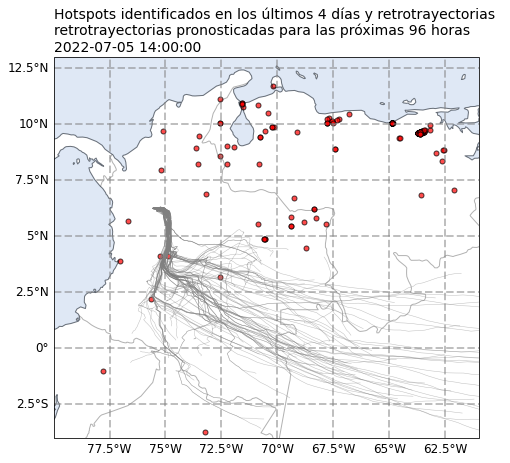

In [141]:
estimator_temp = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators/'+station+'_RF_MO.mdl')

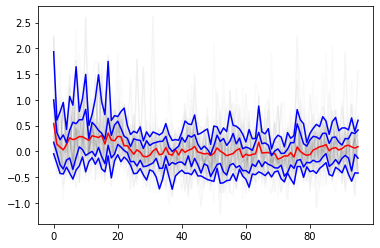

In [148]:
members = predict_probabilities_mo(estimator_temp,x_scaled)

for i in range(len(members)):
    plt.plot(members[i],alpha=0.02,color='k')
plt.plot(estimator_temp.predict(x_scaled)[0],color='red')
plt.plot(np.percentile(members,10,axis=0),color='b')
plt.plot(np.percentile(members,25,axis=0),color='b')
plt.plot(np.percentile(members,75,axis=0),color='b')
plt.plot(np.percentile(members,90,axis=0),color='b')

array([ 0.08414795, -0.13553188, -0.26484462, -0.10220126, -0.18796678,
       -0.02799088, -0.19184177, -0.19795055,  0.10384967, -0.0410967 ,
       -0.08898519, -0.10341745,  0.12795696, -0.06307601,  0.00374373,
       -0.14073868, -0.0657277 ,  0.12744304, -0.01502003,  0.01401869,
        0.06266874,  0.14408184,  0.012169  , -0.02527259, -0.24471982,
       -0.2184919 , -0.17264686, -0.18204127, -0.41640706, -0.46409197,
       -0.28927459, -0.22620015, -0.14845737, -0.33031542, -0.32714337,
       -0.09148784, -0.27811755, -0.18609186, -0.23312007, -0.24849959,
       -0.15932943, -0.13881504, -0.36097039, -0.41578586, -0.16084112,
       -0.25760458, -0.27903872, -0.42651869, -0.16083394, -0.48325199,
       -0.14422206, -0.22832732, -0.02024922, -0.47009107, -0.35280965,
       -0.31285744, -0.35031557, -0.44361781, -0.30467141, -0.33152543,
       -0.34854385, -0.44152934, -0.24445775, -0.29597589, -0.02446856,
       -0.27425822, -0.20616346, -0.26051526, -0.26084177, -0.18

In [135]:
estimator_temp.estimators_[0].

AttributeError: 'NoneType' object has no attribute 'write'

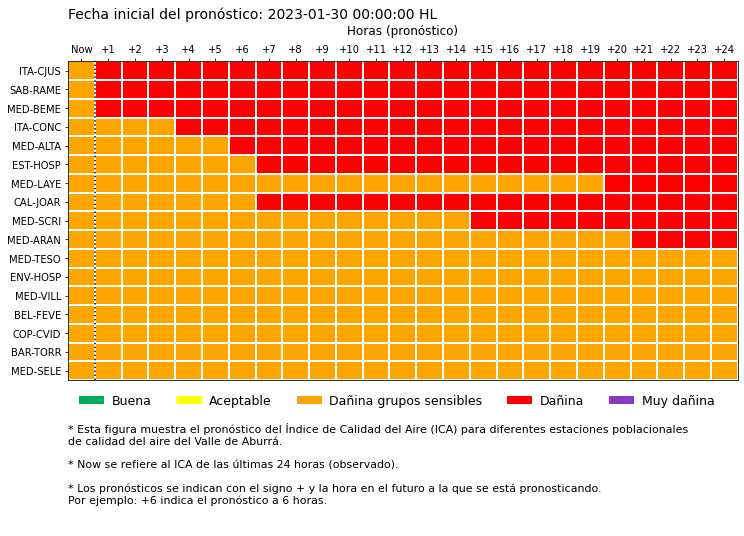

In [21]:
)

In [53]:
def plot_ForeICA24h_pob(date_forecast, path_output):
    #Importando librerías
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    import datetime as dt

    #Importando airquality
    import sys
    sys.path.append('/home/calidadaire/Paquete/')
    import airquality.read_data as aqread
    
    #Definiendo directorio de salida
    dirout_figs = path_output
    
    #Fecha para la lectura del pronóstico
    year = str(date_forecast.year)
    month = str(date_forecast.month).zfill(2)
    day = str(date_forecast.day).zfill(2)
    hour = str(date_forecast.hour).zfill(2)
    
    #Definiendo estaciones
    AQStats = ["ITA-CJUS", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA",
               "MED-VILL", "BAR-TORR", "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI",
               "MED-ARAN", "BEL-FEVE", "ENV-HOSP", "SAB-RAME", "MED-SELE"]
    
    #Para leer información del pronóstico
    datei_for = '{0}-{1}-{2} {3}:00'.format(year, month, day, hour)
    #Para leer información de las observaciones (hasta antes de la hora de inicialización)
    datef_obs = (pd.to_datetime(datei_for) - pd.Timedelta(hours=1)).strftime('%Y-%m-%d %H:%M')
    datei_obs = (pd.to_datetime(datef_obs) - pd.Timedelta(days=1)).strftime('%Y-%m-%d %H:%M')

    #Cargando datos requeridos calidad del aire
    DataObs_PM25 = aqread.PM25(Fechai=datei_obs, Fechaf=datef_obs, estaciones=AQStats)
    DataObs_PM25 = DataObs_PM25.data

    #Creando DataFrame para almacenar la información
    DFTotal_PM25 = pd.DataFrame(DataObs_PM25.mean(axis=0))
    #Dando estructura al DF
    for idx in range(1, 25):
        DFTotal_PM25[idx] = np.nan
    
    
    #Leyendo archivo del pronóstico (con base en la fecha)
    filename = '{0}{1}{2}_{3}.csv'.format(year, month, day, hour)

    #Recorriendo las estaciones
    for aqsta in AQStats:
        #Directorio de entrada
        dirin_data = '/var/data1/AQ_Forecast_DATA/results/{0}/csv/'.format(aqsta)
        #Obteniendo información
        try:
            DataFore_PM25 = pd.read_csv(dirin_data + filename, index_col=[0], parse_dates=[0],
                                        infer_datetime_format=True)
            DataFore_PM25 = DataFore_PM25.mean(axis=1).iloc[:24]
        except:
            continue

        #Guardando información en DataFrame
        DFTotal_PM25.loc[aqsta, range(1, 25)] = DataFore_PM25.values

    #Ordenando dataframe en función de la concentración pronosticada a 6 horas
    DFTotal_PM25.sort_values(6, ascending=False, inplace=True)
    
    
    #GRAFICANDO INFORMACIÓN
    #Definiendo paleta de colores en función del ICA
    import matplotlib as mpl
    cmap = mpl.colors.ListedColormap(['#00ab5c','#ffff01','#fea500','#fe0000','#873ac0'])
    ICAval = [0, 12.6, 37.6, 55.6, 150, 501]
    norm = mpl.colors.BoundaryNorm(ICAval, cmap.N)

    #Creando figura
    fig, ax = plt.subplots(figsize=(12, 12))

    #Graficando información
    ax.imshow(DFTotal_PM25.values*0 + 500, cmap=cmap, norm=norm)

    #Parámetros adicionales
    ax.set_yticks(range(len(DFTotal_PM25)))
    ax.set_yticklabels(DFTotal_PM25.index)
    ax.set_xticks(range(0, 25))
    ax.set_xticklabels(['Now'] + ['+'+str(i) for i in range(1, 25)])
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_aspect(0.7)
    ax.axvline(0.5, color='black', linestyle=':')
    ax.set_xlabel('Horas (pronóstico)', fontsize=12, labelpad=10)
    ax.xaxis.set_label_position('top')


    #Añadiendo grillas
    # Minor ticks
    ax.set_xticks(np.arange(-.5, 25, 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(DFTotal_PM25), 1), minor=True)
    #Grid
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    #Eliminando minor ticks
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    for tick in ax.yaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    #Estableciendo fecha inicial del pronóstico
    plt.title('Fecha inicial del pronóstico: '+str(date_forecast)+ ' HL',
              fontsize=14, loc='left')
    
    
    #Definiendo listas con la información requerida para la leyenda
    Labels = ['Buena', 'Aceptable', 'Dañina grupos sensibles', 'Dañina', 'Muy dañina']
    Colors = ['#00ab5c','#ffff01','#fea500','#fe0000','#873ac0']

    handles = [Patch(facecolor=color, label=label) for label, color in zip(Labels, Colors)]

    #Añadiendo leyenda
    ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(0., -0.01), ncol=5, fontsize=12.5,
              edgecolor='white', handletextpad=0.6)
    
    #Añadiendo texto
    t1 = ("* Esta figura muestra el pronóstico del Índice de Calidad del Aire (ICA) para diferentes estaciones poblacionales\nde calidad del aire del Valle de Aburrá.\n\n"
          "* Now se refiere al ICA de las últimas 24 horas (observado).\n\n"
          "* Los pronósticos se indican con el signo + y la hora en el futuro a la que se está pronosticando.\nPor ejemplo: +6 indica el pronóstico a 6 horas.\n\n")
    text1 = plt.figtext(0.125, 0.15, t1, fontsize=11, wrap=True, horizontalalignment='left')


    #Guardando y mostrando la figura
    #plt.savefig(dirout_figs, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close() 
    
    return DFTotal_PM25[0][0]

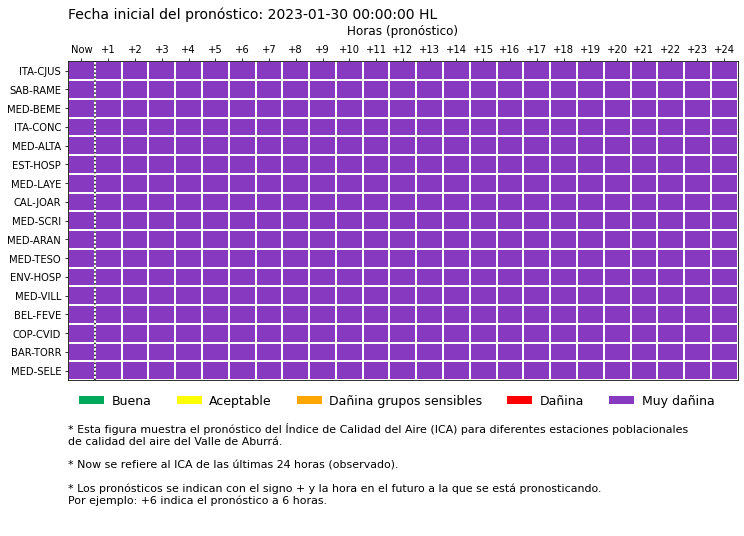

22.166666666666668

In [54]:
from datetime import datetime
date = datetime(2023, 1, 30, 0)
plot_ForeICA24h_pob(date, None)